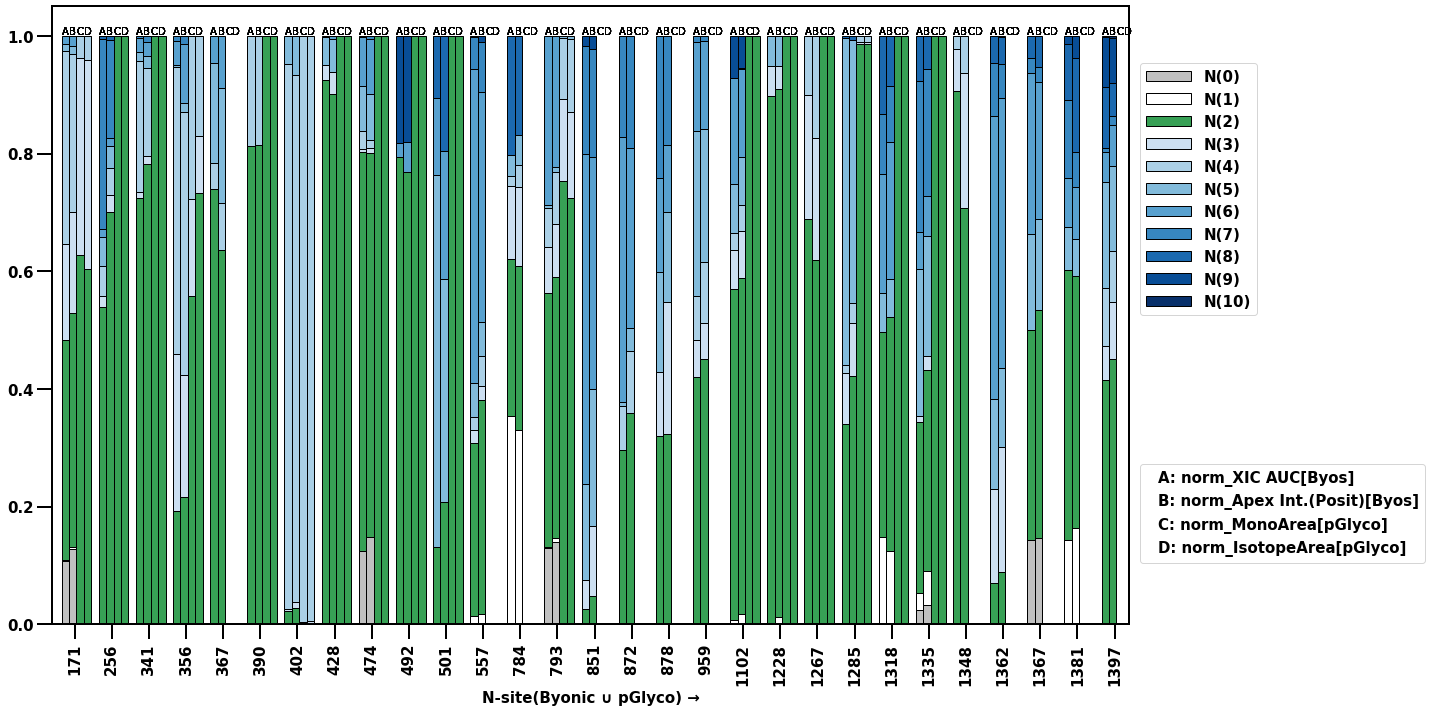

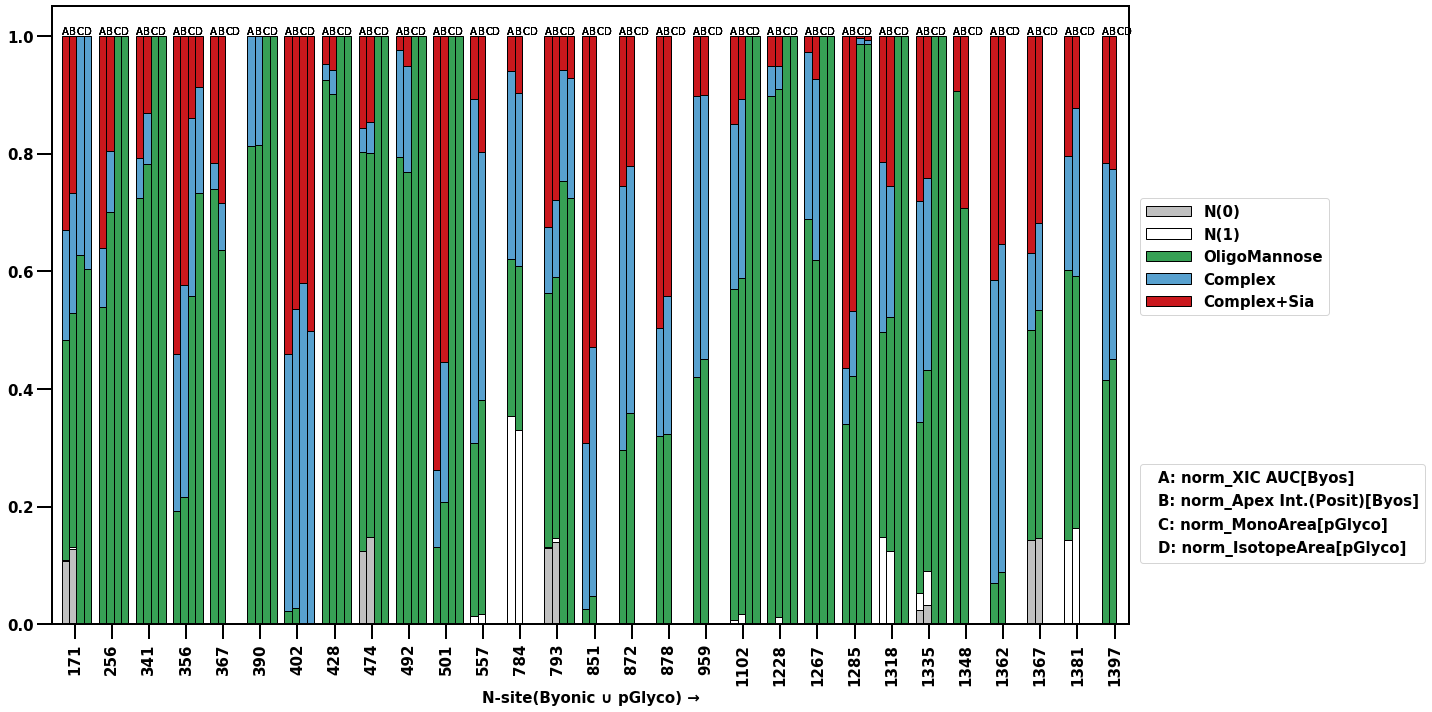

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import ticker
from IPython.display import display, HTML
import re # finding specific patterns in str
import textwrap # split text into equal parts
import collections # return repeated items in list
from collections import OrderedDict
import time
from datetime import datetime # attach current date to export filename
import sys
import ast # convert str back to tuple/list/int, etc
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import string

def plot_clustered_stacked(dfall, nsum, labels=None, title='', neugc_exist=None, tickW=2, tickL=15, spineW=2, xlabelsize=15, ticklabelsize=15, xlabel_rotation=90, xlabelpad=5, legend_fontsize=15, legend_handleL=3, hatch_lineW=1, bar_labelpad=0, bar_labelfontsize=7):
    # Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot
    # labels is a list of the names of the dataframe, used for the legend
    # title is a string for the title of the plot
    # H is the hatch used for identification of the different dataframe
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    k = dfall[0].columns.tolist()
    
    # sample the colormaps
    if neugc_exist is None: # this section caters to v1 plotting
        # extract the largest n number in col to determine the color dict range
        # so that the color-nnumber relation is locked
        n_max = ast.literal_eval(re.findall(r'N\((\d+)\)', k[-1])[0])
        b = plt.cm.Blues(np.linspace(0, 1, (n_max)))[2:] # can be more than N(10)
    gw = plt.cm.gray(np.linspace(0, 1, 5))[-2:]
    single_p = plt.cm.Purples(np.linspace(0, 1, 10))[5]
    single_b = plt.cm.Blues(np.linspace(0, 1, 10))[5]
    single_r = plt.cm.Reds(np.linspace(0, 1, 5))[3]
    single_g = plt.cm.Greens(np.linspace(0, 1, 4))[2]
    
    # combine them and build a new colormap
    if neugc_exist == True: # v2
        colors = np.vstack((gw, single_g, single_b, single_r)) 
        # construct 1 to 1 color dict
        n = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia'] # limited categories
        c = [colors[i] for i in range(len(n))]
        nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
    elif neugc_exist == False: # v2
        colors = np.vstack((gw, single_g, single_b, single_p)) 
        # construct 1 to 1 color dict
        n = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia'] # limited categories
        c = [colors[i] for i in range(len(n))]
        nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
    else: # v1
        colors = np.vstack((gw, single_g, b)) # b is unlimited cmap determined by n_max
        # construct 1 to 1 color dict
        n = ['N(%s)'%i for i in range(n_max+1)] # e.g. N(0)-N(10), can be more than 11 cols # unlimited categories
        c = [colors[i] for i in range(len(n))]
        nc_dict = dict(zip(n, c)) # given k lst, can get v = c. v = nc_dict[k[k_cnt]]
        
    # make tick & spine thick.
    fig, axe = plt.subplots()
    axes = plt.gca()
    axes.xaxis.set_tick_params(width=tickW, length=tickL)
    axes.yaxis.set_tick_params(width=tickW, length=tickL)
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(spineW)
        
    # start plotting
    bar_label = [string.ascii_uppercase[i] for i in range(n_df)]
    bar_label_cnt = 0
    for df in dfall : # for each data frame
        if 'norm' in labels[0]: # add edge to the bar
            axe = df.plot(kind='bar', stacked=True, ax=axe, legend=False, grid=False, figsize =(20, 10), edgecolor = 'k')  # make bar plots
        else: # sum: no edge for clarity
            axe = df.plot(kind='bar', stacked=True, ax=axe, legend=False, grid=False, figsize =(20, 10))  # make bar plots
    # get the y aixs range
    ymin, ymax = axes.get_ylim()
    # get the handles we want to modify in each site, h: 44 barcontainers, l: 4 full N(x) cols
    h,l = axe.get_legend_handles_labels() 
    # print('h:%s\n'%h) 44 <BarContainer object of 29 artists> 
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df -> 0, 11, 22, 33
        k_cnt = 0 # iterate thru k for rect color fix
        for j, pa in enumerate(h[i:i+n_col]): # each pa.patches contains 29 <matplotlib.patches.Rectangle object>
            # print('pa.patches:%s\n'%pa.patches)
            rect_cnt = 0
            for rect in pa.patches: # each rect here is one single N(X) small rect of one single xicauc(int...etc) big rect. Note this loops thru the small rects spanning dif n-sites (iterate thru 29 small rects)
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))    
                rect.set_width(1 / float(n_df + 1))
                axe.text(rect.get_x(), nsum[bar_label_cnt][rect_cnt] + bar_labelpad, bar_label[bar_label_cnt], ha='left', va='bottom')
                rect.set_facecolor(nc_dict[k[k_cnt]]) # use this to fix rect color & legend
                rect_cnt += 1
            k_cnt += 1
        bar_label_cnt += 1
    
    axe.tick_params(axis='both', labelsize=ticklabelsize)
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = xlabel_rotation, fontweight="bold") 
    axe.set_xlabel(df.index.name, fontweight="bold", fontsize = xlabelsize, labelpad = xlabelpad)
    axe.ticklabel_format(axis='y', style='plain')
    for label in axe.get_yticklabels():
        label.set_fontweight('bold')
    axe.set_title(title)
    
    # legend properties
    params = {'legend.fontsize': legend_fontsize, 'legend.handlelength': legend_handleL, 'hatch.linewidth': hatch_lineW}
    legend_properties = {'weight':'bold'}
    plt.rcParams.update(params)
    
    # Add invisible data to add another legend 
    l1 = axe.legend(h[:n_col], l[:n_col], prop=legend_properties, loc=[1.01, 0.5])
    
    legend_elements = [] # for df legend (xicauc, int.. are from dif. df) 
    if labels is not None:      
        for i in range(n_df):
            label = '%s: %s'%(bar_label[i], labels[i])
            each_bullet = Patch(label = label)
            legend_elements.append(each_bullet)
        plt.legend(handles=legend_elements, handlelength = 0, prop=legend_properties, loc=[1.01, 0.1]) # set handleL=0 to hide Patch
    axe.add_artist(l1)
    
    return fig

# DATA OUTPUT CONTROL FLOW
# CURRENT DATE
date = datetime.now().strftime('%Y%m%d')
# bp_union NORM#1
bp_union = pd.read_excel('bp_union.xlsx', header = 0)
bp_union = bp_union.fillna('N/A')
fixed_colname = [i.replace('_x000D_', '\r') if '_x000D_' in i else i for i in bp_union.columns]
bp_union.columns = fixed_colname
# fix the str '10' sorted before '2' problem
nx = list(set(bp_union['N(x) ↓'].tolist()))
nx = [int(re.findall(r'[0-9]+', i)[0]) if type(i) == str else i for i in nx]
nx.sort(key=lambda v: (isinstance(v, str), v))
bp_union_new_nx = ['N(%s)'%(str(i)) if type(i) == int and i != -1 else i for i in nx]
# split bp_union into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucNORM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'a_norm_XIC\r\nAUC[Byos]']]
intNORM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'b_norm_Apex Int.\r\n(Posit)[Byos]']] 
monoNORM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'c_norm_MonoArea[pGlyco]']]
isoNORM_df = bp_union.loc[:, ['N(x) ↓', 'N-site(Byonic ∪ pGlyco) →', 'd_norm_IsotopeArea[pGlyco]']]
xicaucNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
intNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucNORM_df = xicaucNORM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='a_norm_XIC\r\nAUC[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=bp_union_new_nx)
intNORM_df = intNORM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='b_norm_Apex Int.\r\n(Posit)[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=bp_union_new_nx)
monoNORM_df = monoNORM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='c_norm_MonoArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=bp_union_new_nx)
isoNORM_df = isoNORM_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='d_norm_IsotopeArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=bp_union_new_nx)
myfig = plot_clustered_stacked([xicaucNORM_df, intNORM_df, monoNORM_df, isoNORM_df],[[1]*len(xicaucNORM_df.index), [1]*len(intNORM_df.index), [1]*len(monoNORM_df.index), [1]*len(isoNORM_df.index)],['norm_XIC AUC[Byos]', 'norm_Apex Int.(Posit)[Byos]', 'norm_MonoArea[pGlyco]', 'norm_IsotopeArea[pGlyco]'])
myfig.tight_layout()
myfig.savefig(f'{date}_bpUnionNORMv1_Figures.png')

# bp_union NORM#2
col_order = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia']
bp_union.loc[(bp_union['N(x) ↓'] == 'N(0)')|(bp_union['N(x) ↓'] == 'N(1)'), 'nx_version2'] = bp_union['N(x) ↓']
bp_union.loc[(bp_union['N(x) ↓'] == 'N(2)'), 'nx_version2'] = 'OligoMannose'
bp_union.loc[(bp_union['N(x) ↓'] != 'N(0)')&(bp_union['N(x) ↓'] != 'N(1)')&(bp_union['N(x) ↓'] != 'N(2)'), 'nx_version2'] = 'Complex'
bp_union.loc[(bp_union['N(x) ↓'] != 'N(0)')&(bp_union['N(x) ↓'] != 'N(1)')&(bp_union['N(x) ↓'] != 'N(2)')&(bp_union['Glycans ↓'].str.contains('NeuAc|NeuGc')), 'nx_version2'] = 'Complex+Sia'
neugc_exist = sum(bp_union['Glycans ↓'].str.contains('NeuGc')) > 0 # Bool, if T, red. else purple
# split bp_union into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucNORMv2_df = bp_union.loc[:, ['nx_version2', 'N-site(Byonic ∪ pGlyco) →', 'a_norm_XIC\r\nAUC[Byos]']]
intNORMv2_df = bp_union.loc[:, ['nx_version2', 'N-site(Byonic ∪ pGlyco) →', 'b_norm_Apex Int.\r\n(Posit)[Byos]']] 
monoNORMv2_df = bp_union.loc[:, ['nx_version2', 'N-site(Byonic ∪ pGlyco) →', 'c_norm_MonoArea[pGlyco]']]
isoNORMv2_df = bp_union.loc[:, ['nx_version2', 'N-site(Byonic ∪ pGlyco) →', 'd_norm_IsotopeArea[pGlyco]']]
xicaucNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
intNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucNORMv2_df = xicaucNORMv2_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='a_norm_XIC\r\nAUC[Byos]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
intNORMv2_df = intNORMv2_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='b_norm_Apex Int.\r\n(Posit)[Byos]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
monoNORMv2_df = monoNORMv2_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='c_norm_MonoArea[pGlyco]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
isoNORMv2_df = isoNORMv2_df.pivot_table(index='N-site(Byonic ∪ pGlyco) →', values='d_norm_IsotopeArea[pGlyco]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
myfig = plot_clustered_stacked([xicaucNORMv2_df, intNORMv2_df, monoNORMv2_df, isoNORMv2_df],[[1]*len(xicaucNORMv2_df.index), [1]*len(intNORMv2_df.index), [1]*len(monoNORMv2_df.index), [1]*len(isoNORMv2_df.index)],['norm_XIC AUC[Byos]', 'norm_Apex Int.(Posit)[Byos]', 'norm_MonoArea[pGlyco]', 'norm_IsotopeArea[pGlyco]'], neugc_exist=neugc_exist)
myfig.tight_layout()
myfig.savefig(f'{date}_bpUnionNORMv2_Figures.png')

# bp_intersection NORM#1
bp_inter = pd.read_excel('bp_intersection.xlsx', header = 0)
bp_inter = bp_inter.fillna('N/A')
fixed_colname = [i.replace('_x000D_', '\r') if '_x000D_' in i else i for i in bp_inter.columns]
bp_inter.columns = fixed_colname
bp_inter = bp_inter.rename(columns={'N-site(Byonic ∪ pGlyco) →':'N-site(Byonic ∩ pGlyco) →'})
# fix the str '10' sorted before '2' problem
nx = list(set(bp_inter['N(x) ↓'].tolist()))
nx = [int(re.findall(r'[0-9]+', i)[0]) if type(i) == str else i for i in nx]
nx.sort(key=lambda v: (isinstance(v, str), v))
bp_intersection_new_nx = ['N(%s)'%(str(i)) if type(i) == int and i != -1 else i for i in nx]
# split bp_inter into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucNORM_df = bp_inter.loc[:, ['N(x) ↓', 'N-site(Byonic ∩ pGlyco) →', 'a_norm_XIC\r\nAUC[Byos]']]
intNORM_df = bp_inter.loc[:, ['N(x) ↓', 'N-site(Byonic ∩ pGlyco) →', 'b_norm_Apex Int.\r\n(Posit)[Byos]']] 
monoNORM_df = bp_inter.loc[:, ['N(x) ↓', 'N-site(Byonic ∩ pGlyco) →', 'c_norm_MonoArea[pGlyco]']]
isoNORM_df = bp_inter.loc[:, ['N(x) ↓', 'N-site(Byonic ∩ pGlyco) →', 'd_norm_IsotopeArea[pGlyco]']]
xicaucNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
intNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucNORM_df = xicaucNORM_df.pivot_table(index='N-site(Byonic ∩ pGlyco) →', values='a_norm_XIC\r\nAUC[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=bp_intersection_new_nx)
intNORM_df = intNORM_df.pivot_table(index='N-site(Byonic ∩ pGlyco) →', values='b_norm_Apex Int.\r\n(Posit)[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=bp_intersection_new_nx)
monoNORM_df = monoNORM_df.pivot_table(index='N-site(Byonic ∩ pGlyco) →', values='c_norm_MonoArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=bp_intersection_new_nx)
isoNORM_df = isoNORM_df.pivot_table(index='N-site(Byonic ∩ pGlyco) →', values='d_norm_IsotopeArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=bp_intersection_new_nx)
# myfig = plot_clustered_stacked([xicaucNORM_df, intNORM_df, monoNORM_df, isoNORM_df],[[1]*len(xicaucNORM_df.index), [1]*len(intNORM_df.index), [1]*len(monoNORM_df.index), [1]*len(isoNORM_df.index)],['norm_XIC AUC[Byos]', 'norm_Apex Int.(Posit)[Byos]', 'norm_MonoArea[pGlyco]', 'norm_IsotopeArea[pGlyco]']).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_bpInterNORMv1_Figures.png')

# bp_intersection NORM#2
col_order = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia']
bp_inter.loc[(bp_inter['N(x) ↓'] == 'N(0)')|(bp_inter['N(x) ↓'] == 'N(1)'), 'nx_version2'] = bp_inter['N(x) ↓']
bp_inter.loc[(bp_inter['N(x) ↓'] == 'N(2)'), 'nx_version2'] = 'OligoMannose'
bp_inter.loc[(bp_inter['N(x) ↓'] != 'N(0)')&(bp_inter['N(x) ↓'] != 'N(1)')&(bp_inter['N(x) ↓'] != 'N(2)'), 'nx_version2'] = 'Complex'
bp_inter.loc[(bp_inter['N(x) ↓'] != 'N(0)')&(bp_inter['N(x) ↓'] != 'N(1)')&(bp_inter['N(x) ↓'] != 'N(2)')&(bp_inter['Glycans ↓'].str.contains('NeuAc|NeuGc')), 'nx_version2'] = 'Complex+Sia'
neugc_exist = sum(bp_inter['Glycans ↓'].str.contains('NeuGc')) > 0 # Bool, if T, red. else purple
# split bp_union into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucNORMv2_df = bp_inter.loc[:, ['nx_version2', 'N-site(Byonic ∩ pGlyco) →', 'a_norm_XIC\r\nAUC[Byos]']]
intNORMv2_df = bp_inter.loc[:, ['nx_version2', 'N-site(Byonic ∩ pGlyco) →', 'b_norm_Apex Int.\r\n(Posit)[Byos]']] 
monoNORMv2_df = bp_inter.loc[:, ['nx_version2', 'N-site(Byonic ∩ pGlyco) →', 'c_norm_MonoArea[pGlyco]']]
isoNORMv2_df = bp_inter.loc[:, ['nx_version2', 'N-site(Byonic ∩ pGlyco) →', 'd_norm_IsotopeArea[pGlyco]']]
xicaucNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
intNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucNORMv2_df = xicaucNORMv2_df.pivot_table(index='N-site(Byonic ∩ pGlyco) →', values='a_norm_XIC\r\nAUC[Byos]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
intNORMv2_df = intNORMv2_df.pivot_table(index='N-site(Byonic ∩ pGlyco) →', values='b_norm_Apex Int.\r\n(Posit)[Byos]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
monoNORMv2_df = monoNORMv2_df.pivot_table(index='N-site(Byonic ∩ pGlyco) →', values='c_norm_MonoArea[pGlyco]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
isoNORMv2_df = isoNORMv2_df.pivot_table(index='N-site(Byonic ∩ pGlyco) →', values='d_norm_IsotopeArea[pGlyco]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
# myfig = plot_clustered_stacked([xicaucNORMv2_df, intNORMv2_df, monoNORMv2_df, isoNORMv2_df],[[1]*len(xicaucNORMv2_df.index), [1]*len(intNORMv2_df.index), [1]*len(monoNORMv2_df.index), [1]*len(isoNORMv2_df.index)],['norm_XIC AUC[Byos]', 'norm_Apex Int.(Posit)[Byos]', 'norm_MonoArea[pGlyco]', 'norm_IsotopeArea[pGlyco]'], neugc_exist=neugc_exist).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_bpInterNORMv2_Figures.png')

# onlyb NORM#1
onlyb = pd.read_excel('onlyb.xlsx', header = 0)
onlyb = onlyb.fillna('N/A')
fixed_colname = [i.replace('_x000D_', '\r') if '_x000D_' in i else i for i in onlyb.columns]
onlyb.columns = fixed_colname
# fix the str '10' sorted before '2' problem
nx = list(set(onlyb['N(x) ↓'].tolist()))
nx = [int(re.findall(r'[0-9]+', i)[0]) if type(i) == str else i for i in nx]
nx.sort(key=lambda v: (isinstance(v, str), v))
b_new_nx = ['N(%s)'%(str(i)) if type(i) == int and i != -1 else i for i in nx]
# split onlyb into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucNORM_df = onlyb.loc[:, ['N(x) ↓', 'N-site(SequonBased)[Byonic]', 'a_norm_XIC\r\nAUC[Byos]']]
intNORM_df = onlyb.loc[:, ['N(x) ↓', 'N-site(SequonBased)[Byonic]', 'b_norm_Apex Int.\r\n(Posit)[Byos]']] 
xicaucNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
intNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucNORM_df = xicaucNORM_df.pivot_table(index='N-site(SequonBased)[Byonic]', values='a_norm_XIC\r\nAUC[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=b_new_nx)
intNORM_df = intNORM_df.pivot_table(index='N-site(SequonBased)[Byonic]', values='b_norm_Apex Int.\r\n(Posit)[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=b_new_nx)
# myfig = plot_clustered_stacked([xicaucNORM_df, intNORM_df],[[1]*len(xicaucNORM_df.index), [1]*len(intNORM_df.index)],['norm_XIC AUC[Byos]', 'norm_Apex Int.(Posit)[Byos]']).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_onlybNORMv1_Figures.png')

# onlyb NORM#2
col_order = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia']
onlyb.loc[(onlyb['N(x) ↓'] == 'N(0)')|(onlyb['N(x) ↓'] == 'N(1)'), 'nx_version2'] = onlyb['N(x) ↓']
onlyb.loc[(onlyb['N(x) ↓'] == 'N(2)'), 'nx_version2'] = 'OligoMannose'
onlyb.loc[(onlyb['N(x) ↓'] != 'N(0)')&(onlyb['N(x) ↓'] != 'N(1)')&(onlyb['N(x) ↓'] != 'N(2)'), 'nx_version2'] = 'Complex'
onlyb.loc[(onlyb['N(x) ↓'] != 'N(0)')&(onlyb['N(x) ↓'] != 'N(1)')&(onlyb['N(x) ↓'] != 'N(2)')&(onlyb['Glycans ↓'].str.contains('NeuAc|NeuGc')), 'nx_version2'] = 'Complex+Sia'
neugc_exist = sum(onlyb['Glycans ↓'].str.contains('NeuGc')) > 0 # Bool, if T, red. else purple
# split bp_union into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucNORMv2_df = onlyb.loc[:, ['nx_version2', 'N-site(SequonBased)[Byonic]', 'a_norm_XIC\r\nAUC[Byos]']]
intNORMv2_df = onlyb.loc[:, ['nx_version2', 'N-site(SequonBased)[Byonic]', 'b_norm_Apex Int.\r\n(Posit)[Byos]']] 
xicaucNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
intNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucNORMv2_df = xicaucNORMv2_df.pivot_table(index='N-site(SequonBased)[Byonic]', values='a_norm_XIC\r\nAUC[Byos]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
intNORMv2_df = intNORMv2_df.pivot_table(index='N-site(SequonBased)[Byonic]', values='b_norm_Apex Int.\r\n(Posit)[Byos]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
# myfig = plot_clustered_stacked([xicaucNORMv2_df, intNORMv2_df],[[1]*len(xicaucNORMv2_df.index), [1]*len(intNORMv2_df.index)],['norm_XIC AUC[Byos]', 'norm_Apex Int.(Posit)[Byos]'], neugc_exist=neugc_exist).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_onlybNORMv2_Figures.png')


# onlyb SUM#1
# split bp_union into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucSUM_df = onlyb.loc[:, ['N(x) ↓', 'N-site(SequonBased)[Byonic]', 'e_sum_XIC\r\nAUC[Byos]']]
intSUM_df = onlyb.loc[:, ['N(x) ↓', 'N-site(SequonBased)[Byonic]', 'f_sum_Apex Int.\r\n(Posit)[Byos]']] 
xicaucSUM_df.replace(to_replace = -1, value = np.nan , inplace = True)
intSUM_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucSUM_df = xicaucSUM_df.pivot_table(index='N-site(SequonBased)[Byonic]', values='e_sum_XIC\r\nAUC[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=b_new_nx)
intSUM_df = intSUM_df.pivot_table(index='N-site(SequonBased)[Byonic]', values='f_sum_Apex Int.\r\n(Posit)[Byos]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=b_new_nx)
xicaucSUM_df_nsum = [xicaucSUM_df.loc[i].sum() for i in xicaucSUM_df.index.tolist()] # for A bar label
intSUM_df_nsum = [intSUM_df.loc[i].sum() for i in intSUM_df.index.tolist()] # for B bar label
nsum = [xicaucSUM_df_nsum, intSUM_df_nsum]
# myfig = plot_clustered_stacked([xicaucSUM_df, intSUM_df],nsum,['sum_XIC AUC[Byos]', 'sum_Apex Int.(Posit)[Byos]']).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_onlybSUMv1_Figures.png')

# onlyb SUM#2
col_order = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia']
onlyb.loc[(onlyb['N(x) ↓'] == 'N(0)')|(onlyb['N(x) ↓'] == 'N(1)'), 'nx_version2'] = onlyb['N(x) ↓']
onlyb.loc[(onlyb['N(x) ↓'] == 'N(2)'), 'nx_version2'] = 'OligoMannose'
onlyb.loc[(onlyb['N(x) ↓'] != 'N(0)')&(onlyb['N(x) ↓'] != 'N(1)')&(onlyb['N(x) ↓'] != 'N(2)'), 'nx_version2'] = 'Complex'
onlyb.loc[(onlyb['N(x) ↓'] != 'N(0)')&(onlyb['N(x) ↓'] != 'N(1)')&(onlyb['N(x) ↓'] != 'N(2)')&(onlyb['Glycans ↓'].str.contains('NeuAc|NeuGc')), 'nx_version2'] = 'Complex+Sia'
# split onlyb into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
xicaucSUMv2_df = onlyb.loc[:, ['nx_version2', 'N-site(SequonBased)[Byonic]', 'e_sum_XIC\r\nAUC[Byos]']]
intSUMv2_df = onlyb.loc[:, ['nx_version2', 'N-site(SequonBased)[Byonic]', 'f_sum_Apex Int.\r\n(Posit)[Byos]']] 
xicaucSUMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
intSUMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
xicaucSUMv2_df = xicaucSUMv2_df.pivot_table(index='N-site(SequonBased)[Byonic]', values='e_sum_XIC\r\nAUC[Byos]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
intSUMv2_df = intSUMv2_df.pivot_table(index='N-site(SequonBased)[Byonic]', values='f_sum_Apex Int.\r\n(Posit)[Byos]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
xicaucSUMv2_df_nsum = [xicaucSUMv2_df.loc[i].sum() for i in xicaucSUMv2_df.index.tolist()] # for A bar label
intSUMv2_df_nsum = [intSUMv2_df.loc[i].sum() for i in intSUMv2_df.index.tolist()] # for B bar label
nsum = [xicaucSUMv2_df_nsum, intSUMv2_df_nsum]
# myfig = plot_clustered_stacked([xicaucSUMv2_df, intSUMv2_df],nsum ,['sum_XIC AUC[Byos]', 'sum_Apex Int.(Posit)[Byos]'], neugc_exist=neugc_exist).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_onlybSUMv2_Figures.png')

# onlyp NORM#1
onlyp = pd.read_excel('onlyp.xlsx', header = 0)
onlyp = onlyp.fillna('N/A')
fixed_colname = [i.replace('_x000D_', '\r') if '_x000D_' in i else i for i in onlyp.columns]
onlyp.columns = fixed_colname
# fix the str '10' sorted before '2' problem
nx = list(set(onlyp['N(x) ↓'].tolist()))
nx = [int(re.findall(r'[0-9]+', i)[0]) if type(i) == str else i for i in nx]
nx.sort(key=lambda v: (isinstance(v, str), v))
p_new_nx = ['N(%s)'%(str(i)) if type(i) == int and i != -1 else i for i in nx]
# split bp_union into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
monoNORM_df = onlyp.loc[:, ['N(x) ↓', 'ProSites[pGlyco]', 'c_norm_MonoArea[pGlyco]']]
isoNORM_df = onlyp.loc[:, ['N(x) ↓', 'ProSites[pGlyco]', 'd_norm_IsotopeArea[pGlyco]']]
monoNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoNORM_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoNORM_df = monoNORM_df.pivot_table(index='ProSites[pGlyco]', values='c_norm_MonoArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=p_new_nx)
isoNORM_df = isoNORM_df.pivot_table(index='ProSites[pGlyco]', values='d_norm_IsotopeArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=p_new_nx)
# myfig = plot_clustered_stacked([monoNORM_df, isoNORM_df],[[1]*len(monoNORM_df.index), [1]*len(isoNORM_df.index)],['norm_MonoArea[pGlyco]', 'norm_IsotopeArea[pGlyco]']).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_onlypNORMv1_Figures.png')

# onlyp NORM#2
col_order = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia']
onlyp.loc[(onlyp['N(x) ↓'] == 'N(0)')|(onlyp['N(x) ↓'] == 'N(1)'), 'nx_version2'] = onlyp['N(x) ↓']
onlyp.loc[(onlyp['N(x) ↓'] == 'N(2)'), 'nx_version2'] = 'OligoMannose'
onlyp.loc[(onlyp['N(x) ↓'] != 'N(0)')&(onlyp['N(x) ↓'] != 'N(1)')&(onlyp['N(x) ↓'] != 'N(2)'), 'nx_version2'] = 'Complex'
onlyp.loc[(onlyp['N(x) ↓'] != 'N(0)')&(onlyp['N(x) ↓'] != 'N(1)')&(onlyp['N(x) ↓'] != 'N(2)')&(onlyp['Glycans ↓'].str.contains('NeuAc|NeuGc')), 'nx_version2'] = 'Complex+Sia'
neugc_exist = sum(onlyp['Glycans ↓'].str.contains('NeuGc')) > 0 # Bool, if T, red. else purple
# split onlyp into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
monoNORMv2_df = onlyp.loc[:, ['nx_version2', 'ProSites[pGlyco]', 'c_norm_MonoArea[pGlyco]']]
isoNORMv2_df = onlyp.loc[:, ['nx_version2', 'ProSites[pGlyco]', 'd_norm_IsotopeArea[pGlyco]']]
monoNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoNORMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoNORMv2_df = monoNORMv2_df.pivot_table(index='ProSites[pGlyco]', values='c_norm_MonoArea[pGlyco]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
isoNORMv2_df = isoNORMv2_df.pivot_table(index='ProSites[pGlyco]', values='d_norm_IsotopeArea[pGlyco]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
# myfig = plot_clustered_stacked([monoNORMv2_df, isoNORMv2_df],[[1]*len(monoNORMv2_df.index), [1]*len(isoNORMv2_df.index)],['norm_MonoArea[pGlyco]', 'norm_IsotopeArea[pGlyco]'], neugc_exist=neugc_exist).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_onlypNORMv2_Figures.png')

# onlyp SUM#1
# split onlyp into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
monoSUM_df = onlyp.loc[:, ['N(x) ↓', 'ProSites[pGlyco]', 'g_sum_MonoArea[pGlyco]']]
isoSUM_df = onlyp.loc[:, ['N(x) ↓', 'ProSites[pGlyco]', 'h_sum_IsotopeArea[pGlyco]']] 
monoSUM_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoSUM_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoSUM_df = monoSUM_df.pivot_table(index='ProSites[pGlyco]', values='g_sum_MonoArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=p_new_nx)
isoSUM_df = isoSUM_df.pivot_table(index='ProSites[pGlyco]', values='h_sum_IsotopeArea[pGlyco]', columns='N(x) ↓', aggfunc=np.sum).reindex(columns=p_new_nx)
monoSUM_df_nsum = [monoSUM_df.loc[i].sum() for i in monoSUM_df.index.tolist()] # for A bar label
isoSUM_df_nsum = [isoSUM_df.loc[i].sum() for i in isoSUM_df.index.tolist()] # for B bar label
nsum = [monoSUM_df_nsum, isoSUM_df_nsum]
# myfig = plot_clustered_stacked([monoSUM_df, isoSUM_df],nsum,['sum_MonoArea[pGlyco]', 'sum_IsotopeArea[pGlyco]']).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_onlypSUMv1_Figures.png')

# onlyp SUM#2
col_order = ['N(0)', 'N(1)', 'OligoMannose', 'Complex', 'Complex+Sia']
onlyp.loc[(onlyp['N(x) ↓'] == 'N(0)')|(onlyp['N(x) ↓'] == 'N(1)'), 'nx_version2'] = onlyp['N(x) ↓']
onlyp.loc[(onlyp['N(x) ↓'] == 'N(2)'), 'nx_version2'] = 'OligoMannose'
onlyp.loc[(onlyp['N(x) ↓'] != 'N(0)')&(onlyp['N(x) ↓'] != 'N(1)')&(onlyp['N(x) ↓'] != 'N(2)'), 'nx_version2'] = 'Complex'
onlyp.loc[(onlyp['N(x) ↓'] != 'N(0)')&(onlyp['N(x) ↓'] != 'N(1)')&(onlyp['N(x) ↓'] != 'N(2)')&(onlyp['Glycans ↓'].str.contains('NeuAc|NeuGc')), 'nx_version2'] = 'Complex+Sia'
# split onlyp into: xicauc_df / int_df / mono_df / iso_df for later clustered stacked plot (norm only)
monoSUMv2_df = onlyp.loc[:, ['nx_version2', 'ProSites[pGlyco]', 'g_sum_MonoArea[pGlyco]']]
isoSUMv2_df = onlyp.loc[:, ['nx_version2', 'ProSites[pGlyco]', 'h_sum_IsotopeArea[pGlyco]']] 
monoSUMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
isoSUMv2_df.replace(to_replace = -1, value = np.nan , inplace = True)
monoSUMv2_df = monoSUMv2_df.pivot_table(index='ProSites[pGlyco]', values='g_sum_MonoArea[pGlyco]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
isoSUMv2_df = isoSUMv2_df.pivot_table(index='ProSites[pGlyco]', values='h_sum_IsotopeArea[pGlyco]', columns='nx_version2', aggfunc=np.sum).reindex(columns=col_order)
monoSUMv2_df_nsum = [monoSUMv2_df.loc[i].sum() for i in monoSUMv2_df.index.tolist()] # for A bar label
isoSUMv2_df_nsum = [isoSUMv2_df.loc[i].sum() for i in isoSUMv2_df.index.tolist()] # for B bar label
nsum = [monoSUMv2_df_nsum, isoSUMv2_df_nsum]
# myfig = plot_clustered_stacked([monoSUMv2_df, isoSUMv2_df],nsum ,['sum_MonoArea[pGlyco]', 'sum_IsotopeArea[pGlyco]'], neugc_exist=neugc_exist).figure
# myfig.tight_layout()
# myfig.savefig(f'{date}_onlypSUMv2_Figures.png')

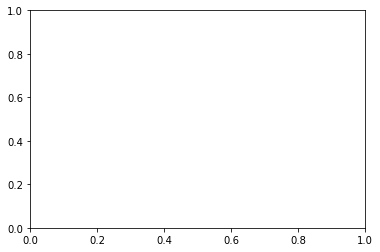

In [1]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# # c = [['#ccffcc', '#008000']] + plt.cm.Blues(np.linspace(0, 1, 9))
# # c = plt.cm.Blues(np.linspace(0, 1, 9))


# # sample the colormaps
# # colors in total
# g = plt.cm.Greens(np.linspace(0, 1, 2))
# b = plt.cm.Blues(np.linspace(0, 1, 9))
# # combine them and build a new colormap
# colors = np.vstack((g, b))
# # mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
# print(colors)
# a = [[1, 2]]
# b = [[3, 4], [5, 6]]
# a+b
fig, axe = plt.subplots()
# plt.subplots(1, 1)